In [1]:
# import module

import numpy as np
import matplotlib.pyplot as plt
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro.analysis import PPStatistic
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as const

In [2]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)
def fit_gaussian(x, y):
    initial_height = max(y)
    initial_center = x[np.argmax(y)]
    initial_width = 1
    initial_params = [initial_height, initial_center, initial_width]
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_params)
    return popt
def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev
def analyze_spectra(coordinates_list, data):
    spectra_list = []
    for i, j in coordinates_list:
        spectra_list.append(data[:, i, j])
    spe = np.sum(spectra_list, axis=0)
    x_spe = np.arange(len(spe))
    params = fit_gaussian(x_spe, spe)
    fwhm = calculate_fwhm(params[2])
    return params, fwhm

<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_12396\3489086208.py:12: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')


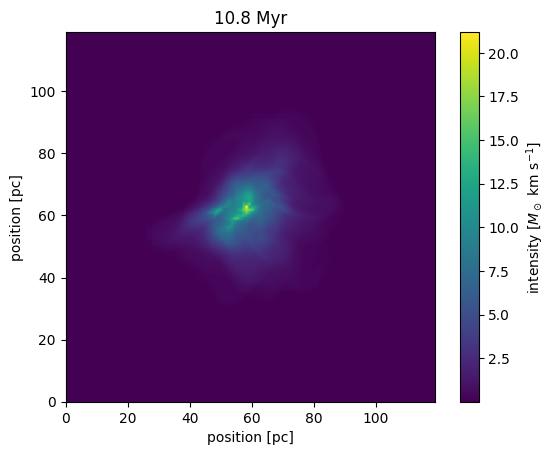

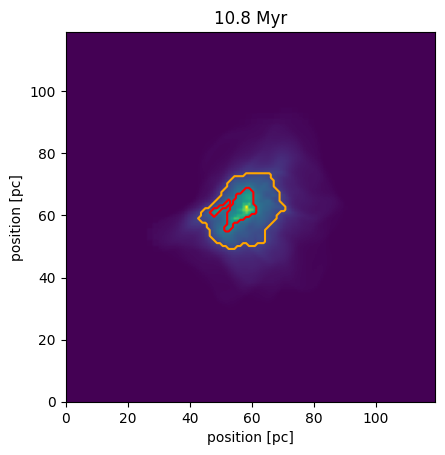

In [3]:
data = np.load("D:/simdata/m4r20z1a1/data/5000.npz")
pc = data['arr_1']
m = data["arr_2"]
int_map = np.sum(m, axis=0) * 0.65
extent = [0, pc * m.shape[1], 0, pc * m.shape[2]]
fig, ax = plt.subplots()
im = ax.imshow(int_map, extent=extent, origin='lower')
ax.set_title("10.8 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')
cbar = fig.colorbar(im)
cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')
plt.show()
#plt.savefig("int_map_400")

min_value = 3 * np.std(int_map)
min_delta = np.std(int_map)
min_npix = 10
dendro = Dendrogram.compute(int_map, min_value=min_value, min_delta=min_delta, min_npix=min_npix)
leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(int_map, extent=extent, origin='lower')
p = dendro.plotter()
for s in leaf_indices:
    p.plot_contour(ax, extent=extent, structure=s, colors='red')
for s in branch_indices:
    p.plot_contour(ax, extent=extent, structure=s, colors='orange')
ax.set_title("10.8 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')
plt.show()
#plt.savefig("dendro_400_contour")

size, radius, mass, v_dispersion, vir_param = [], [], [], [], []
for index in leaf_indices:
    s = dendro[index]
    npix = s.get_npix()
    size.append(round(npix * pc**2, 0))
    radius.append(round(np.sqrt(npix * pc**2 / np.pi), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(round(np.sum(int_map[indices]) / 0.65, 6))
    coordinates_list = list(zip(indices[0], indices[1]))
    params, fwhm = analyze_spectra(coordinates_list, m)
    v_dispersion.append(round(fwhm * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           np.sqrt(npix * pc**2 / np.pi) * 
                           (fwhm * 0.65)**2 / 
                           (3 * (np.sum(int_map[indices]) / 0.65)), 6))
results_leaves = pd.DataFrame({'size': size, 
                               'radius': radius, 
                               'mass': mass, 
                                'velocity dispersion': v_dispersion,
                               'virial parameter': vir_param})
size, radius, mass, v_dispersion, vir_param = [], [], [], [], []
for index in branch_indices:
    s = dendro[index]
    npix = s.get_npix()
    size.append(round(npix * pc**2, 0))
    radius.append(round(np.sqrt(npix * pc**2 / np.pi), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(round(np.sum(int_map[indices]) / 0.65, 6))
    spectra_list = []
    coordinates_list = list(zip(indices[0], indices[1]))
    params, fwhm = analyze_spectra(coordinates_list, m)
    v_dispersion.append(round(fwhm * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           np.sqrt(npix * pc**2 / np.pi) * 
                           (fwhm * 0.65)**2 / 
                           (3 * (np.sum(int_map[indices]) / 0.65)), 6))
results_branches = pd.DataFrame({'size': size, 
                                 'radius': radius, 
                                 'mass': mass,
                                 'velocity dispersion': v_dispersion,
                                 'virial parameter': vir_param})
results_leaves.to_csv("results_leaves_5000.csv")
results_branches.to_csv("results_branches_5000.csv")